In [50]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

sns.set_theme(style="white", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


print (glob.glob("../geom_aligned_curves/*.npy"))
# curve_bs = np.array(curve_bs)
curve_bs = np.load("../geom_aligned_curves/geomstats_aligned_to_first.npy")
curve_cs = np.load("../geom_aligned_curves/geomstats_aligned_to_frechet.npy")
unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves/total_files_with_a.npy")[:curve_bs.shape[0]]

print (curve_bs.shape)
print (curve_cs.shape)
print (unaligned_curvatures.shape)
print (files.shape)

brava_num = 79

k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_

curvatures = []
torsions = []

for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(curve_cs[i]*100)
    fft_c = remove_high_freq_components(c,0.06)
    fft_t = remove_high_freq_components(t,0.06)
    curvatures.append(fft_c)
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)


g_dist_to_frechet = []
for i in range(len(curve_cs)):
    g_dist_to_frechet.append(curves_r3.metric.dist(mean_estimate, curve_cs[i]))
g_dist_to_frechet = np.array(g_dist_to_frechet)

# 获取按距离从小到大排序的索引
sorted_indices = np.argsort(g_dist_to_frechet)

# 根据这些索引重新排列距离数组
g_dist_to_frechet = g_dist_to_frechet[sorted_indices]

# 对曲率进行相应的从大到小排序
curvatures = curvatures[sorted_indices]
torsions = torsions[sorted_indices]
files = files[sorted_indices]
curve_cs = curve_cs[sorted_indices]
curve_bs = curve_bs[sorted_indices]

g_dist_min = 100000
g_dist_max = 0
g_dist_min_index = (0,0)
g_dist_max_index = (0,0)
g_dist = []
g_dist_mat = np.zeros((len(curve_bs),len(curve_bs)))
for i in range(len(curve_bs)):
    # geodesic_distance = curves_r3.metric.dist(mean_estimate, curve_bs[i])
    for j in range(len(curve_bs)):
        g_dist_mat[i,j] = curves_r3.metric.dist(curve_bs[i], curve_bs[j])
    
    if i != j and g_dist_mat[i,j] < g_dist_min:
        g_dist_min = g_dist_mat[i,j]
        g_dist_min_index = (i,j)
    elif i != j and g_dist_mat[i,j] > g_dist_max:
        g_dist_max = g_dist_mat[i,j]
        g_dist_max_index = (i,j)
    g_dist.append(g_dist_mat[i,j])
print (g_dist_min_index, g_dist_max_index)


time = np.linspace(0, 1, len(curvatures[0]))  # 时间点
f = curvatures.copy().T  # 数据
# f = sample_c.T
obj_curvature = fs.fdawarp(f,time)
# 执行对齐
obj_curvature.srsf_align(parallel=True, MaxItr=3000)

f = torsions.copy().T  # 数据
obj_torsion = fs.fdawarp(f,time)
# 执行对齐
obj_torsion.srsf_align(parallel=True, MaxItr=10000)

c_peak_indices, _ = find_peaks(obj_curvature.fmean, height=0)
t_peak_indices, _ = find_peaks(obj_torsion.fmean, height=0)
c_peak_indices = c_peak_indices[:5]
t_peak_indices = t_peak_indices[:5]
print (c_peak_indices)

c_peak_values = []
t_peak_values = []
c_peak_movement = []
t_peak_movement = []
for i in range(len(curvatures)):
    c_peak_values.append(obj_curvature.fn[:,i][c_peak_indices]/obj_curvature.fmean[c_peak_indices])
    t_peak_values.append(obj_torsion.fn[:,i][t_peak_indices]/obj_torsion.fmean[t_peak_indices])
    c_peak_movement.append(obj_curvature.gam[:,i][c_peak_indices] - c_peak_indices/len(curvatures[0]))
    t_peak_movement.append(obj_curvature.gam[:,i][t_peak_indices] - t_peak_indices/len(curvatures[0]))
    
c_peak_values = np.array(c_peak_values)
t_peak_values = np.array(t_peak_values)
c_peak_movement = np.array(c_peak_movement)
t_peak_movement = np.array(t_peak_movement)
print (c_peak_values.shape)
print (c_peak_movement.shape)

c_peak_values_transposed = list(zip(*c_peak_values))
t_peak_values_transposed = list(zip(*t_peak_values))

kappa_moves = []
tau_moves = []
kappa_values = []
tau_values = []
for i in range(len(curvatures)):
    kappa_moves.append(np.mean(c_peak_movement[i]))
    tau_moves.append(np.mean(t_peak_movement[i]))
    kappa_values.append(np.mean(c_peak_values[i]))
    tau_values.append(np.mean(t_peak_values[i]))
kappa_moves = np.array(kappa_moves)
tau_moves = np.array(tau_moves)
kappa_values = np.array(kappa_values)
tau_values = np.array(tau_values)

['../geom_aligned_curves\\curvatures.npy', '../geom_aligned_curves\\geomstats_aligned_to_first.npy', '../geom_aligned_curves\\geomstats_aligned_to_first_with_a.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet.npy', '../geom_aligned_curves\\geomstats_aligned_to_frechet_with_a.npy', '../geom_aligned_curves\\total_files_with_a.npy']
(79, 119, 3)
(79, 119, 3)
(79, 120)
(79,)


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


(62, 78) (76, 78)
Initializing...
Compute Karcher Mean of 79 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
updating step: r=21
updating step: r=22
updating step: r=23
updating step: r=24
updating step: r=25
updating step: r=26
updating step: r=27
updating step: r=28
updating step: r=29
updating step: r=30
updating step: r=31
updating step: r=32
updating step: r=33
updating step: r=34
updating step: r=35
updating step: r=36
updating step: r=37
updating step: r=38
updating step: r=39
updating step: r=40
updating step: r=41
updating step: r=42
updating step: r=43
updating step: r=44
updating step: r=45
updatin

- The first curve is not aligned in `curve_bs`.
- `curve_bs` and `curve_cs` have the same parameterization.

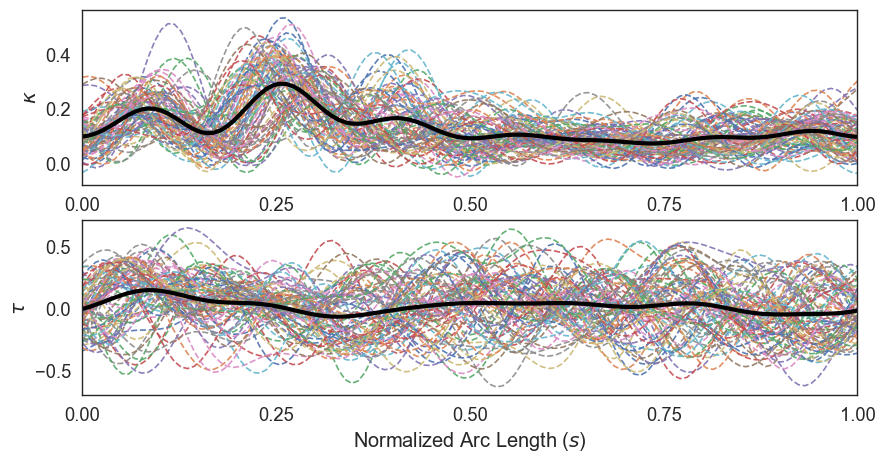

In [51]:
# 假设 curvatures 是已定义的，每个元素的长度为120
# siphon_ranges 为每个curvatures中siphon段的起始和结束索引列表



sns.set_context("paper", font_scale=1.5)
fig = plt.figure(figsize=(10, 5), dpi=100)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 2])

ax1 = fig.add_subplot(gs[0, 0])  # 第一行，第一列
ax2 = fig.add_subplot(gs[1, 0])  # 第二行，第一列
# ax3 = fig.add_subplot(gs[2, 0])  # 第三行，第一列 (用于绘制KDE)

# 绘制curvatures和torsions的线图
for i in range(len(curvatures)):
    sns.lineplot(x=np.arange(len(curvatures[i])), y=curvatures[i], ax=ax1, alpha=0.9, linestyle='--', linewidth=1.2)
    sns.lineplot(x=np.arange(len(torsions[i])), y=torsions[i], ax=ax2, alpha=0.9, linestyle='--', linewidth=1.2)

sns.lineplot(x=np.arange(len(np.mean(curvatures, axis=0))), y=np.mean(curvatures, axis=0), ax=ax1, color='black', linewidth=3)
sns.lineplot(x=np.arange(len(np.mean(torsions, axis=0))), y=np.mean(torsions, axis=0), ax=ax2, color='black', linewidth=3)


# # 绘制原始概率分布
# ax3.fill_between(range(120), siphon_probability, color="skyblue", alpha=0.4)

# # 绘制高斯拟合曲线
# ax3.plot(x_values, fitted_pdf, ':', linewidth=2, label='Gaussian Fit',color="dimgray")


def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


set_x_ticks_normalized(ax1,curvatures[0])
set_x_ticks_normalized(ax2,torsions[0])
ax1.set_ylabel('$\kappa$')
ax2.set_ylabel('$\\tau$')
ax2.set_xlabel('Normalized Arc Length ($s$)')
plt.show()



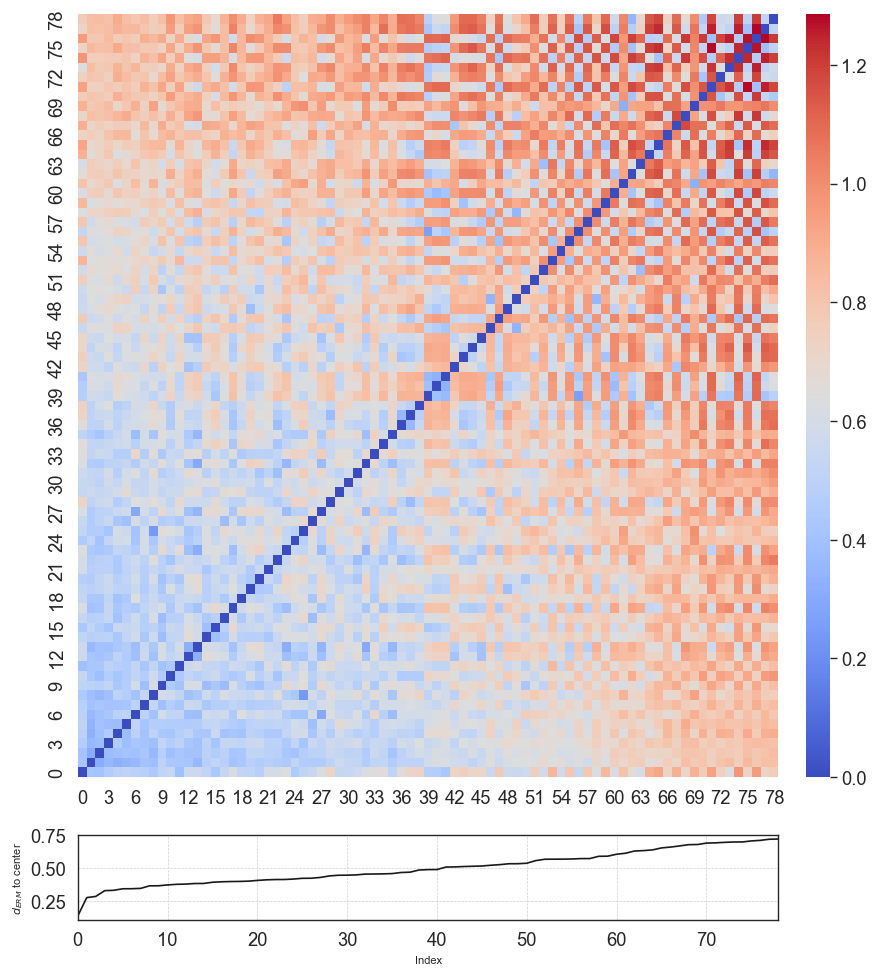

In [52]:

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_subplot(111)
# sns.heatmap(g_dist_mat,ax=ax, cmap='crest_r')
# ax.invert_yaxis()
# # ax.set_xticks([])
# # ax.set_yticks([])
# g_dist_center = np.mean(g_dist_mat, axis=0)


fig = plt.figure(figsize=(9, 10), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[9, 1], width_ratios=[30, 1])
# The first subplot (standard deviation line plot).
ax1 = fig.add_subplot(gs[0, 0])  # First row, first column
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
cbar_ax = fig.add_subplot(gs[0, 1])  # Span both rows, second column

sns.heatmap(g_dist_mat,ax=ax1, cmap='coolwarm',cbar_ax=cbar_ax)
# CS = ax1.contour(g_dist_mat, colors='black', levels=20, linewidths=0.5)

ax2.plot(g_dist_to_frechet, 'k')  # 'k' is the color black for the line plot
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.9)
ax2.set_ylabel('$d_{ERM}$ to center', fontsize=8)
ax2.set_xlabel('Index', fontsize=8)
ax2.autoscale(enable=True, axis='x', tight=True)
# Adding contour labels
# ax1.clabel(CS, inline=True, fontsize=8)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

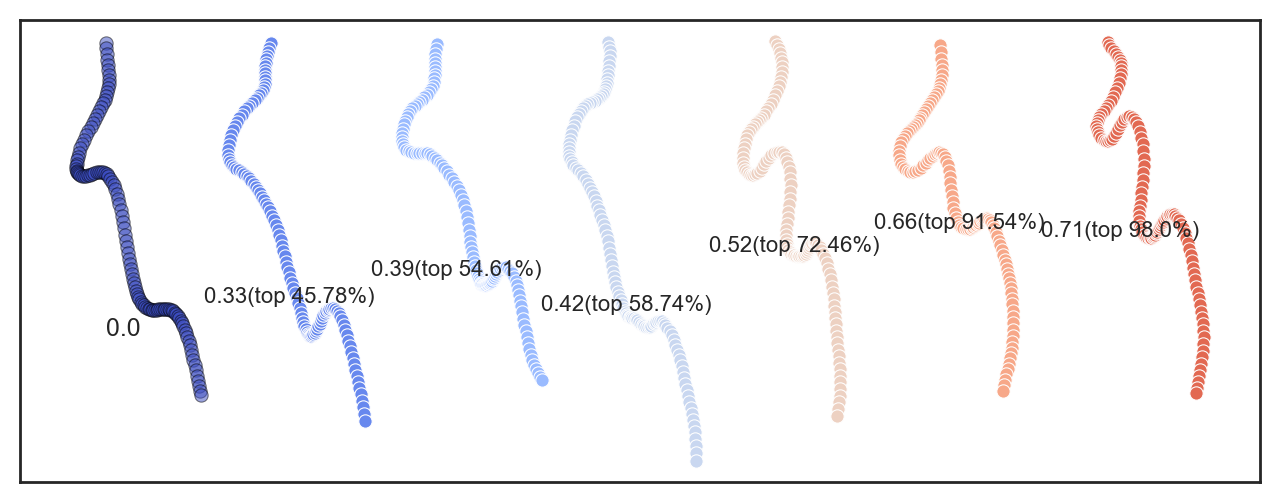

In [53]:
color_palette_1 = sns.color_palette("coolwarm", as_cmap=True)

fig = plt.figure(figsize=(8, 3), dpi=200)
ax = fig.add_subplot(111)
example_idx = [3, 15, 25, 46, 66,75]
g_dist_examples = g_dist_to_frechet[example_idx]
sns.scatterplot(x=mean_estimate[:,2]*1.2,y=mean_estimate[:,1]*1.2, color=color_palette_1(0), ax=ax, alpha=0.5,edgecolor='black')
plt.text(mean_estimate[0,2],mean_estimate[-1,1],'0.0', fontsize=9)
for i in range(len(example_idx)):
    idx = example_idx[i]
    sns.scatterplot(x=curve_bs[idx,:,2]+(i+1)*0.5,y=curve_bs[idx,:,1],  alpha=1, color = color_palette_1((i+1)/(len(example_idx)+1)), ax=ax)
    plt.text(curve_bs[idx,0,2]-0.2+(i+1)*0.5,curve_bs[idx,-50,1],str(round(g_dist_examples[i],2))+"(top {}%)".format(round(g_dist_examples[i]/np.max(g_dist_to_frechet)*100,2)), fontsize=8)

ax.set_yticks([])
ax.set_xticks([])
plt.show()



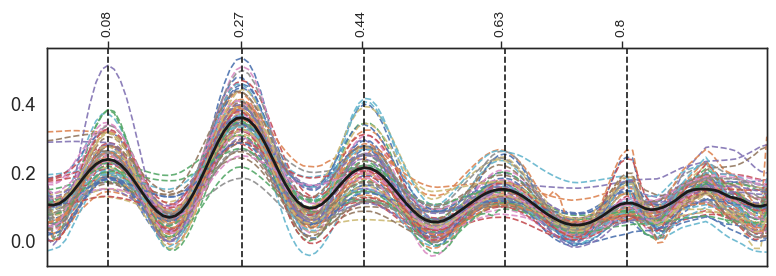

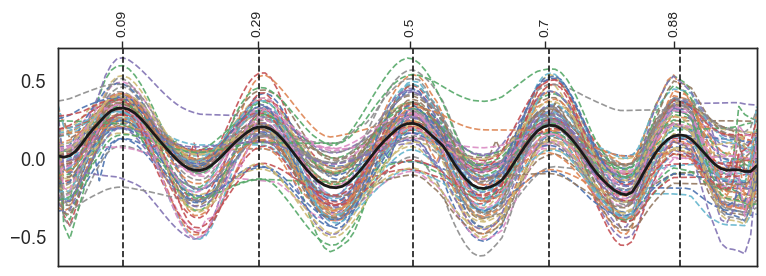

In [58]:
from scipy.signal import find_peaks

def align_curvature(curvatures,MaxItr=100):
    time = np.linspace(0, 1, len(curvatures[0]))  # 时间点
    f = curvatures.copy().T  # 数据
    # f = sample_c.T
    obj_curvature = fs.fdawarp(f,time)
    # 执行对齐
    obj_curvature.srsf_align(parallel=True, MaxItr=MaxItr)
    return obj_curvature

def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)

color_list_hex = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.add_subplot(111)
for i in range(obj_curvature.fn.shape[1]):
    sns.lineplot(x=range(len(curvatures[0])), y=obj_curvature.fn[:,i], alpha=0.9, ax=ax, linestyle='--')
sns.lineplot(x=range(len(curvatures[0])), y=obj_curvature.fmean, alpha=1, ax=ax, c='k', linewidth=2)

peak_indices, _ = find_peaks(obj_curvature.fmean, height=0)
for peak_index in peak_indices[:-1]:
    p_len = round(peak_index/len(curvatures[0]),2)
    ax.axvline(x=peak_index, c='k', linestyle='--')

ax2 = ax.twiny()
ax2.set_xticks(peak_indices[:5]/len(curvatures[0]))
ax2.set_xticklabels([str(round(index/len(curvatures[0]),2)) for index in peak_indices[:5]], rotation=90, fontsize=10)

# set_x_ticks_normalized(ax,curvatures[0],2)
ax.set_xticks([])
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

fig = plt.figure(figsize=(8,3), dpi=100)
ax = fig.add_subplot(111)
for i in range(obj_curvature.fn.shape[1]):
    sns.lineplot(x=range(len(curvatures[0])), y=obj_torsion.fn[:,i], alpha=0.9, ax=ax, linestyle='--')
sns.lineplot(x=range(len(curvatures[0])), y=obj_torsion.fmean, alpha=1, ax=ax, c='k', linewidth=2)
# for i in range(5):
#     ax.text(c_peak_indices[i], 0.5, str(round(c_peak_indices[i]/len(curvatures[0]),2)), fontsize=12)
peak_indices, _ = find_peaks(obj_torsion.fmean, height=0)
for peak_index in peak_indices:
    p_len = round(peak_index/len(curvatures[0]),2)
    ax.axvline(x=peak_index, c='k', linestyle='--')

ax2 = ax.twiny()
ax2.set_xticks(peak_indices[:5]/len(curvatures[0]))
ax2.set_xticklabels([str(round(index/len(curvatures[0]),2)) for index in peak_indices[:5]], rotation=90, fontsize=10)

# set_x_ticks_normalized(ax,curvatures[0],2)
ax.set_xticks([])
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()


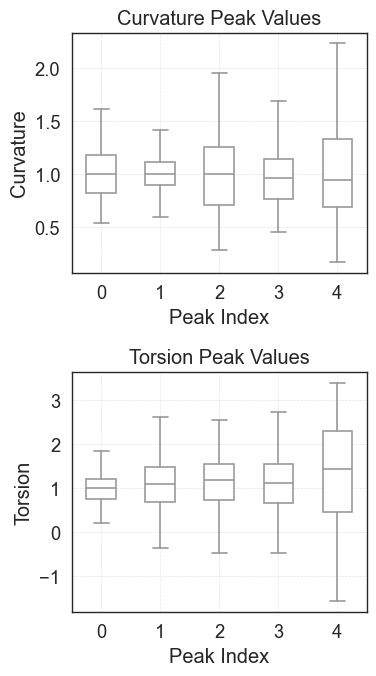

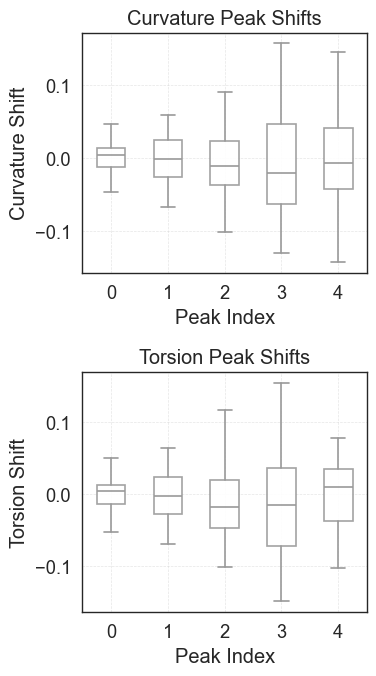

In [59]:
import pandas as pd

example_indices = [60,5,53]

fig = plt.figure(figsize=(4,7), dpi=100)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# # Drawing boxplots for curvature peak values
# for i in range(len(c_peak_values)):
#     ax1.scatter(range(5), c_peak_values[i], alpha=0.3, marker='x', c='k')
#     ax2.scatter(range(5), t_peak_values[i], alpha=0.3, marker='x', c='k')

sns.boxplot(data=c_peak_values_transposed, ax=ax1, color='w', boxprops=dict(alpha=0.99),width=0.5,showfliers=False)
sns.boxplot(data=t_peak_values_transposed, ax=ax2, color='w', boxprops=dict(alpha=0.99),width=0.5,showfliers=False)


# for i in range(len(example_indices)):
#     ax1.scatter(range(5), c_peak_values[example_indices[i]])
#     ax2.scatter(range(5), t_peak_values[example_indices[i]])

ax1.set_title('Curvature Peak Values')
ax1.set_xlabel('Peak Index')
ax1.set_ylabel('Curvature')
# ax1.set_ylim(0,1)

ax2.set_title('Torsion Peak Values')
ax2.set_xlabel('Peak Index')
ax2.set_ylabel('Torsion')
# ax2.set_ylim(-1,1)
ax1.grid(linewidth=0.5, linestyle='--', alpha=0.5)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(4, 7), dpi=100)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.boxplot(data=c_peak_movement, ax=ax1, color='w', boxprops=dict(alpha=0.9),width=0.5,showfliers=False)
sns.boxplot(data=t_peak_movement, ax=ax2, color='w', boxprops=dict(alpha=0.9),width=0.5,showfliers=False)

# for i in range(len(example_indices)):
#     ax1.scatter(range(5), c_peak_movement[example_indices[i]])
#     ax2.scatter(range(5), t_peak_movement[example_indices[i]])
ax1.set_title('Curvature Peak Shifts')
ax1.set_xlabel('Peak Index')
ax1.set_ylabel('Curvature Shift')
# ax1.set_ylim(-1,1)
ax2.set_title('Torsion Peak Shifts')
ax2.set_xlabel('Peak Index')
ax2.set_ylabel('Torsion Shift')
# ax2.set_ylim(-1,1)
ax1.grid(linewidth=0.5, linestyle='--', alpha=0.5)
ax2.grid(linewidth=0.5, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# print (c_peak_movement)

df_c_peak_values = pd.DataFrame(c_peak_values_transposed)
df_t_peak_values = pd.DataFrame(t_peak_values_transposed)
df_c_peak_movement = pd.DataFrame(c_peak_movement)
df_t_peak_movement = pd.DataFrame(t_peak_movement)
df_c_peak_movement.to_csv('curvature_peak_movement.csv')
df_t_peak_movement.to_csv('torsion_peak_movement.csv')
df_c_peak_values.to_csv('curvature_peak_values.csv')
df_t_peak_values.to_csv('torsion_peak_values.csv')

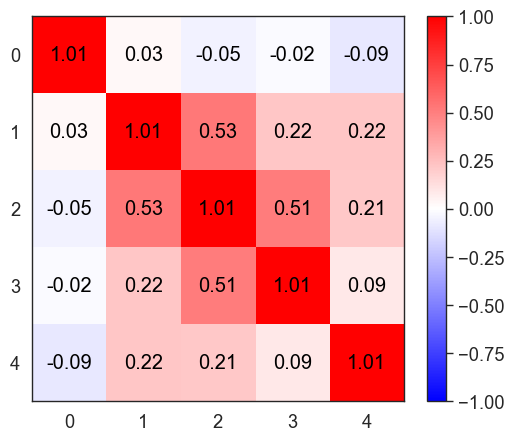

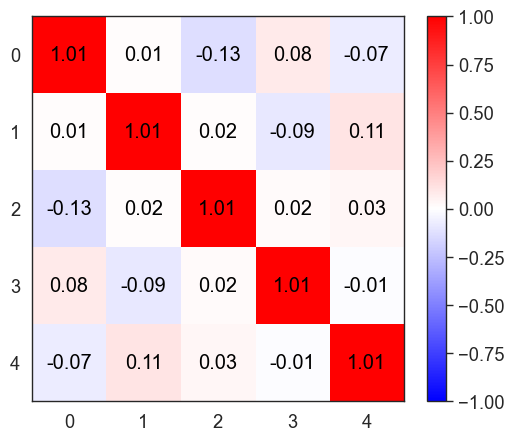

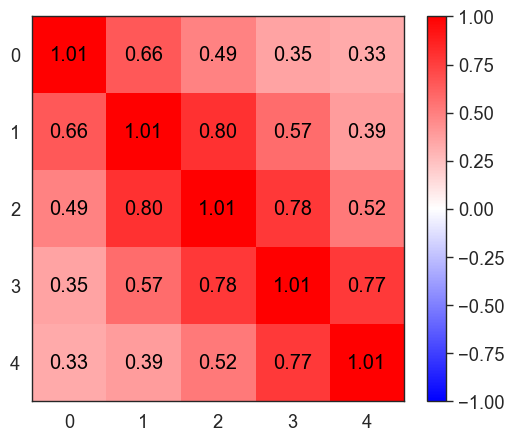

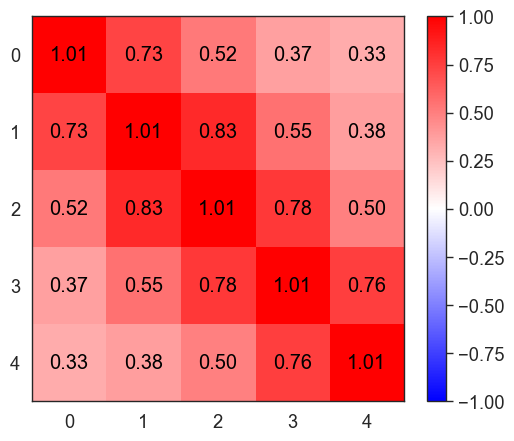

In [7]:
def plot_with_imshow(matrix, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(matrix, cmap='bwr', aspect='auto',vmin=-1, vmax=1)

    # 在每个格子上标注数值，精确到小数点后两位
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black')

    # plt.title(title)
    plt.colorbar(cax)
    plt.grid(False)
    plt.show()
    return matrix

# 计算自协方差矩阵
c_autocovariance_values = autocovariance_function(min_max_normalize(np.array(c_peak_values)))
t_autocovariance_values = autocovariance_function(min_max_normalize(np.array(t_peak_values)))
c_movement_autocovariance_values = autocovariance_function(min_max_normalize(c_peak_movement))
t_movement_autocovariance_values = autocovariance_function(min_max_normalize(t_peak_movement))

# 可视化自协方差矩阵
mat_c = plot_with_imshow(c_autocovariance_values, 'Curvature Autocovariance Matrix')
mat_t = plot_with_imshow(t_autocovariance_values, 'Torsion Autocovariance Matrix')
mat_c_movement = plot_with_imshow(c_movement_autocovariance_values, 'Curvature Movement Autocovariance Matrix')
mat_t_movement = plot_with_imshow(t_movement_autocovariance_values, 'Torsion Movement Autocovariance Matrix')


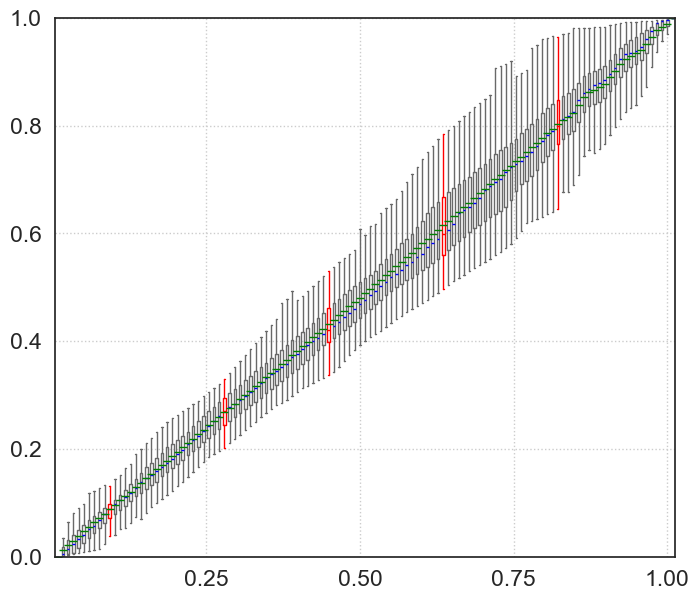

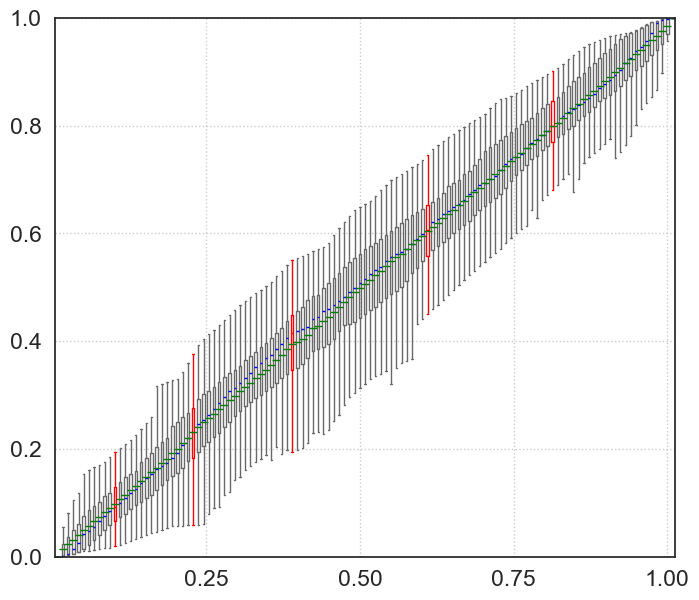

In [8]:
meanprops = {
    "marker": "_",
    "markeredgecolor": "green",
    "markerfacecolor": "green",
    # "markersize": 25
}

sns.set_context("notebook", font_scale=1.5)

for obj, peak_indices in zip([obj_curvature, obj_torsion], [c_peak_indices, t_peak_indices]):

    fig = plt.figure(figsize=(8,7), dpi=100, facecolor='w')
    ax = fig.add_subplot(111)
    boxprops = {'color': 'dimgray', 'linewidth': 1}
    medianprops = {'color': 'blue', 'linewidth': 1}
    bp = ax.boxplot(obj.gam.T, showmeans=True, showfliers=False, medianprops=medianprops, meanprops=meanprops, boxprops=boxprops, whiskerprops=boxprops, capprops=boxprops)

    for peak in peak_indices:
        # Change the color of the boxplot elements at the peak indices
        plt.setp(bp['boxes'][peak], color='red')
        plt.setp(bp['whiskers'][2*peak], color='red')
        plt.setp(bp['whiskers'][2*peak + 1], color='red')
        plt.setp(bp['caps'][2*peak], color='red')
        plt.setp(bp['caps'][2*peak + 1], color='red')
        plt.setp(bp['medians'][peak], color='red')

    # ax.plot([0, 120], [0, 1], linestyle=':', color='k', alpha=0.5, linewidth=3)
    # for peak in peak_indices:
    #     ax.axvline(x=peak, c='k', linewidth=3, alpha=0.5)
    
    set_x_ticks_normalized(ax, obj.gam)
    ax.autoscale(enable=True, axis='y', tight=True)
    ax.grid(linewidth=1, linestyle=':', alpha=1)
    plt.show()

显然并不需要说fPCA,只需要讲srsf对齐.
对齐后根据warping function查看伸缩情况即可.

In [9]:
vpca_curvature = fs.fdavpca(obj_curvature)
vpca_curvature.calc_fpca(no=3)
hpca_curvature = fs.fdahpca(obj_curvature)
hpca_curvature.calc_fpca(no=3)
jpca_curvature = fs.fdajpca(obj_curvature)
jpca_curvature.calc_fpca(no=3)

vpca_torsion = fs.fdavpca(obj_torsion)
vpca_torsion.calc_fpca(no=3)
hpca_torsion = fs.fdahpca(obj_torsion)
hpca_torsion.calc_fpca(no=3)
jpca_torsion = fs.fdajpca(obj_torsion)
jpca_torsion.calc_fpca(no=3)


[0.30080839 0.25808424 0.2034918  0.0872229  0.05101093 0.04767171
 0.01079038 0.01031609 0.00868062 0.00405452 0.00322879 0.00265433
 0.00210639 0.00194452 0.00151303 0.00132296]


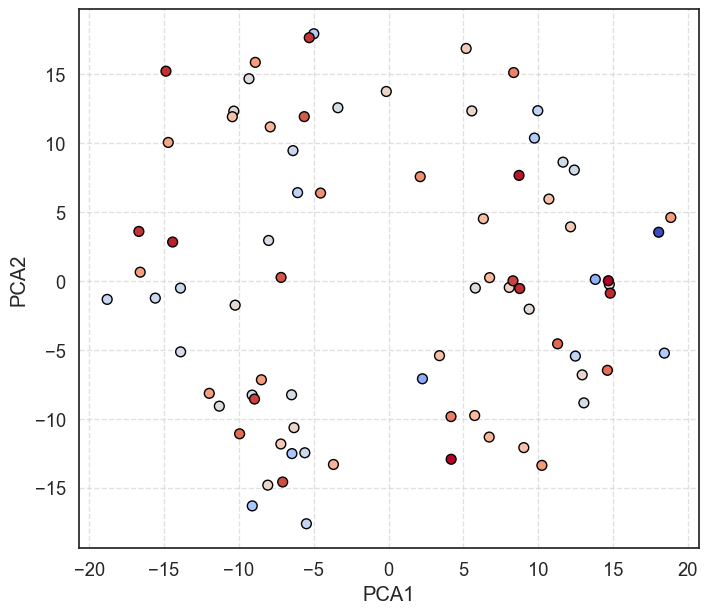

In [63]:
from scipy.spatial.transform import Rotation as R

def random_transform_curve(curve_cs):
    # Copy the array to avoid modifying the original
    transformed_curves = np.copy(curve_cs)
    
    for i in range(curve_cs.shape[0]):
        # Generate a random rotation
        rotation = R.from_euler('xyz', np.random.uniform(0, 360, 3), degrees=True)
        
        # Generate a random scale factor between 0.9 and 1.1
        scale_factor = np.random.uniform(0.9, 1.1)
        
        # Apply the rotation and scale to each point in the curve
        transformed_curves[i] = rotation.apply(curve_cs[i]) * scale_factor
    
    return transformed_curves

translate_curve = random_transform_curve(curve_cs)

pca = PCA(n_components=16)

standard_coordinate = StandardScaler().fit_transform(translate_curve.reshape(len(curve_cs),-1))
# print (standard_coordinate.shape)
results = pca.fit_transform(standard_coordinate)
print (pca.explained_variance_ratio_)

sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(8, 7), dpi=100)
ax = fig.add_subplot(111)
ax.scatter(results[:,0],results[:,1],c=g_dist_to_frechet, cmap='coolwarm', edgecolor='black', s=50)
ax.grid(linestyle='--', alpha=0.6)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
plt.show()


(79, 16)


array([0.39690109, 0.20759248, 0.18275613, 0.07918031, 0.02633007,
       0.02272125, 0.02095439, 0.01317999, 0.01198089, 0.00757386,
       0.00530045, 0.00463232, 0.00343275, 0.00273876, 0.00248908,
       0.00193466])

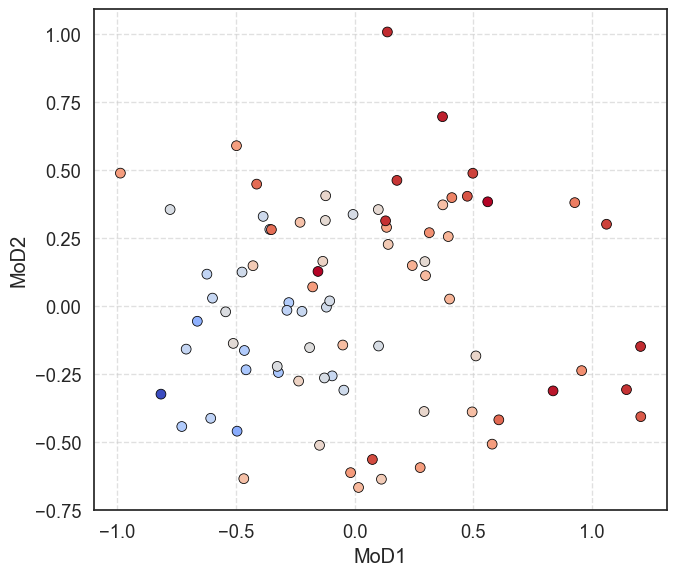

In [11]:
from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
tPCA_N_COMPONENTS = 16

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

print (tangent_projected_data.shape)
# 步骤4: 分析和可视化结果
sns.set_context('notebook', font_scale=1.2)
fig = plt.figure(figsize=(7, 6))
ax1 = fig.add_subplot(111)
x = tangent_projected_data[:, 0]
y = tangent_projected_data[:, 1]
z = g_dist_to_frechet
grid_x, grid_y = np.mgrid[min(x):max(x):10j, min(y):max(y):10j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')
grid_z = gaussian_filter(grid_z, sigma=0.07)  # sigma是平滑程度的参数

sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c=g_dist_to_frechet,ax=ax1, cmap='coolwarm',s=50)
# contours = plt.contour(grid_x, grid_y, grid_z, levels=10, cmap='crest_r', alpha=0.69)
# plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')  # 在等高线上添加数值标签

ax1.grid(linestyle='--', alpha=0.6 )
ax1.set_xlabel('MoD1')
ax1.set_ylabel('MoD2')
ax1.autoscale(enable=True, axis='x', tight=False)
plt.tight_layout()
tpca.explained_variance_ratio_

#0 curvature peak VS 6 MoD: 0.46
#0 torsion peak VS 7 MoD: -0.31
#1 curvature peak VS 1 MoD: 0.36
#1 curvature peak VS 5 MoD: -0.34
#1 torsion peak VS 10 MoD: 0.34
#2 curvature peak VS 0 MoD: 0.40
#2 curvature peak VS 1 MoD: 0.39
#2 curvature peak VS 5 MoD: -0.47
#2 curvature peak VS 7 MoD: 0.34
#2 torsion peak VS 10 MoD: 0.42
#3 curvature peak VS 0 MoD: 0.33
#3 curvature peak VS 3 MoD: 0.31
#3 curvature peak VS 5 MoD: -0.39
#4 curvature peak VS 1 MoD: 0.48
#4 curvature peak VS 3 MoD: 0.33


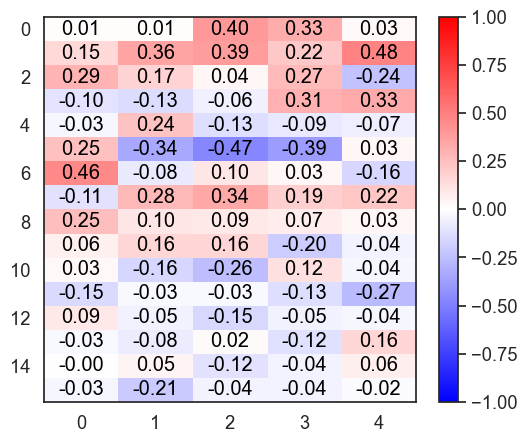

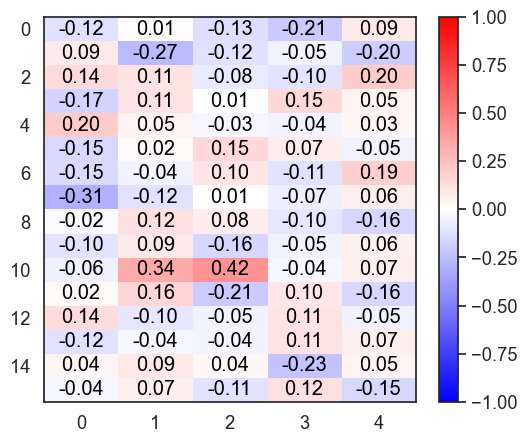

array([[-0.12149548,  0.00821538, -0.13109874, -0.2051144 ,  0.08794498],
       [ 0.08505922, -0.27162898, -0.12040021, -0.04804494, -0.20061116],
       [ 0.14174698,  0.11222764, -0.07992244, -0.10178565,  0.19969945],
       [-0.16534358,  0.11163688,  0.00508205,  0.15055726,  0.0466933 ],
       [ 0.20312768,  0.05257239, -0.03157915, -0.04220547,  0.03185221],
       [-0.15191965,  0.02097686,  0.15300673,  0.07349584, -0.0506458 ],
       [-0.14768026, -0.0420291 ,  0.10166743, -0.11075248,  0.19164525],
       [-0.30659486, -0.11663641,  0.01283046, -0.06843803,  0.06285498],
       [-0.01626845,  0.1199168 ,  0.07657219, -0.09845187, -0.15738195],
       [-0.10294249,  0.08732669, -0.15765125, -0.04722586,  0.05962994],
       [-0.05750701,  0.33547532,  0.41500311, -0.03848005,  0.07010621],
       [ 0.01988674,  0.16054809, -0.20720728,  0.10105202, -0.15678203],
       [ 0.13783961, -0.0988366 , -0.05463002,  0.11460589, -0.04756458],
       [-0.12308254, -0.03555138, -0.0

In [12]:
mat = np.zeros((tPCA_N_COMPONENTS,5,2))
for i in range(5):
    for j in range(tPCA_N_COMPONENTS):
        c = np.corrcoef(tangent_projected_data[:,j], c_peak_values[:,i])[0,1]
        t = np.corrcoef(tangent_projected_data[:,j], t_peak_values[:,i])[0,1]
        mat[j,i,0] = c
        mat[j,i,1] = t
        if abs(c) > 0.3:
            print ("#{} curvature peak VS {} MoD: {:.2f}".format(i,j,c))
        if abs(t) > 0.3:
            print ("#{} torsion peak VS {} MoD: {:.2f}".format(i,j,t))

plot_with_imshow(mat[:,:,0], 'Curvature Peaks Correlation')
plot_with_imshow(mat[:,:,1], 'Torsion Peaks Correlation')

In [13]:
from scipy.stats import norm


def from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, PCA_N_COMPONENTS, discrete_curves_space):
    principal_components = tpca.components_
    # Assuming principal_components has the shape (n_components, n_sampling_points * n_dimensions)
    point_num = len(tangent_base)
    principal_components_reshaped = principal_components.reshape((PCA_N_COMPONENTS, point_num, 3)) # point_num是采样点数
    # Now use exp on each reshaped component
    curves_from_components = [
        discrete_curves_space.metric.exp(tangent_vec=component, base_point=tangent_base)
        for component in principal_components_reshaped
    ]

    reconstructed_curves = []
    for idx in range(len(tangent_projected_data)):
        # This is your feature - a single point in PCA space representing the loadings for the first curve.
        feature = np.array(tangent_projected_data[idx])
        # Reconstruct the tangent vector from the feature.
        # print ("feature:", feature.shape)
        # print ("principal_components_reshaped:", principal_components_reshaped.shape)
        # print ("idx:", idx)
        tangent_vector_reconstructed = sum(feature[i] * principal_components_reshaped[i] for i in range(len(feature)))
        # Map the tangent vector back to the curve space using the exponential map.
        reconstructed_curve = discrete_curves_space.metric.exp(
            tangent_vec=tangent_vector_reconstructed, base_point=tangent_base
        )
        # reconstructed_curve = inverse_srvf(reconstructed_srvf, np.zeros(3))
        # print ("reconstructed_curve length:", measure_length(reconstructed_curve))# length=63
        
        reconstructed_curves.append(reconstructed_curve)
    reconstructed_curves = np.array(reconstructed_curves)
    return reconstructed_curves

discrete_curves_space = curves_r3
print (tPCA_N_COMPONENTS)
reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, tangent_projected_data, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)

total_l2d = []
for curve_idx in range(79):
    l2d = []
    # for i in [1,2,3,5,10,15]:
    for i in range(tPCA_N_COMPONENTS):
        ft = tangent_projected_data[curve_idx,:].copy()
        # print (ft.shape)
        ft[i:] = 0
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                                    tPCA_N_COMPONENTS, 
                                                                                    discrete_curves_space)[0]
        least_squares_error = curves_r3.metric.dist(curve_cs[curve_idx], reconstructed_step_curve)
        l2d.append(least_squares_error)
    total_l2d.append(l2d)


16


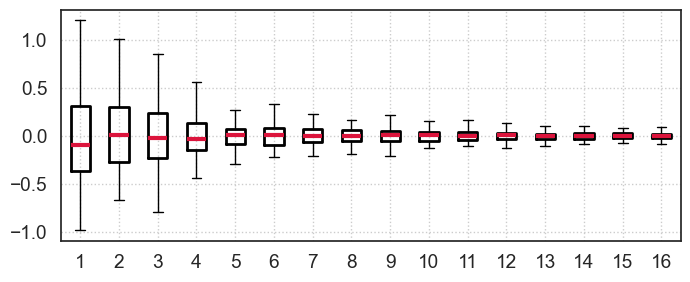

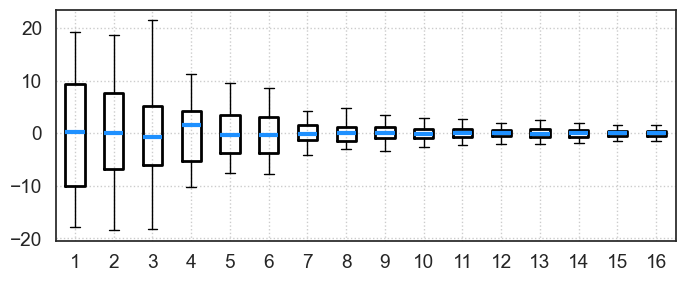

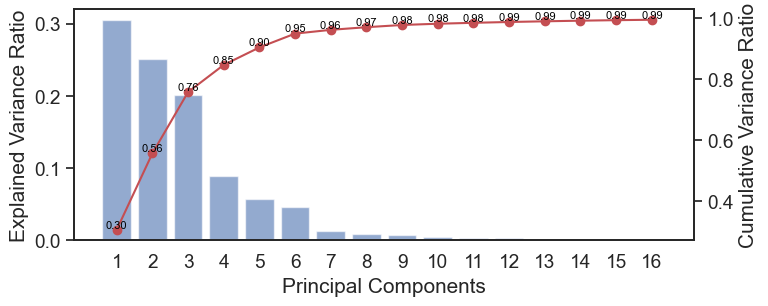

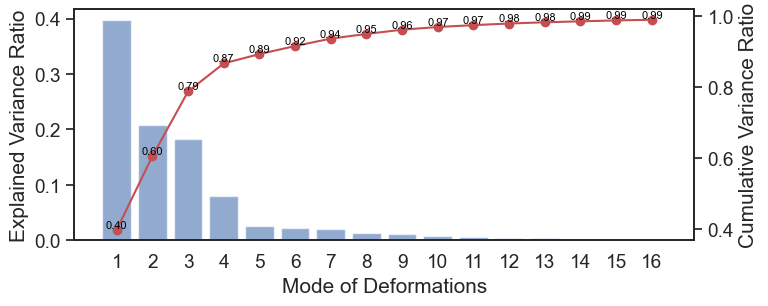

In [14]:
sns.set_context('notebook', font_scale=1.25)

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot(tangent_projected_data, showfliers=False, medianprops={'color': 'crimson', 'linewidth': 3},boxprops={'color': 'black', 'linewidth': 2})
ax.grid(linewidth=1, linestyle=':', alpha=1)
plt.show()

fig = plt.figure(figsize=(8, 3), dpi=100)
ax = fig.add_subplot(111)
ax.boxplot(results, showfliers=False, medianprops={'color': 'dodgerblue', 'linewidth': 3},boxprops={'color': 'black', 'linewidth': 2})
ax.grid(linewidth=1, linestyle=':', alpha=1)
plt.show()


# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=100, facecolor='w')

# Bar plot for explained variance ratio
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Explained Variance Ratio')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative variance ratio
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-', marker='o', label='Cumulative Variance Ratio')
# Adding height annotations
for i, val in enumerate(cumulative_variance_ratio):
    ax2.text(i + 1, val, f'{val:.2f}', ha='center', va='bottom', fontsize=8, color='black')
ax2.set_ylabel('Cumulative Variance Ratio')

# # Adding legends
# fig.legend()

# plt.title('Explained Variance Ratio and Cumulative Variance Ratio')
plt.show()


# Explained variance ratio
explained_variance_ratio = tpca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
# Plotting
fig, ax1 = plt.subplots(figsize=(8, 3), dpi=100, facecolor='w')

# Bar plot for explained variance ratio
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Explained Variance Ratio')
ax1.set_xlabel('Mode of Deformations')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_xticks(range(1, len(explained_variance_ratio) + 1))

# Line plot for cumulative variance ratio
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'r-', marker='o', label='Cumulative Variance Ratio')
# Adding height annotations
for i, val in enumerate(cumulative_variance_ratio):
    ax2.text(i + 1, val, f'{val:.2f}', ha='center', va='bottom', fontsize=8, color='black')

ax2.set_ylabel('Cumulative Variance Ratio')

# # Adding legends
# fig.legend()

# plt.title('Explained Variance Ratio and Cumulative Variance Ratio')
plt.show()


(16,)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23972217160245815, 0.23972217160245815, 0.2656752067595596, 0.2656752067595596, 0.2942433567420146, 0.2942433567420146, 0.29991396808997084, 0.29991396808997084, 0.3086550214668495, 0.3086550214668495, 0.312658799759599, 0.312658799759599, 0.3185657032088423, 0.3185657032088423, 0.3240627944458835, 0.3240627944458835, 0.3252840015734353, 0.3252840015734353, 0.33394575440891355, 0.33394575440891355, 0.3366347620723955, 0.3366347620723955, 0.3412124156585592, 0.3412124156585592, 0.34504703672256226, 0.34504703672256226, 0.35000616136344476, 0.35000616136344476, 0.3527652519786433, 0.35276525

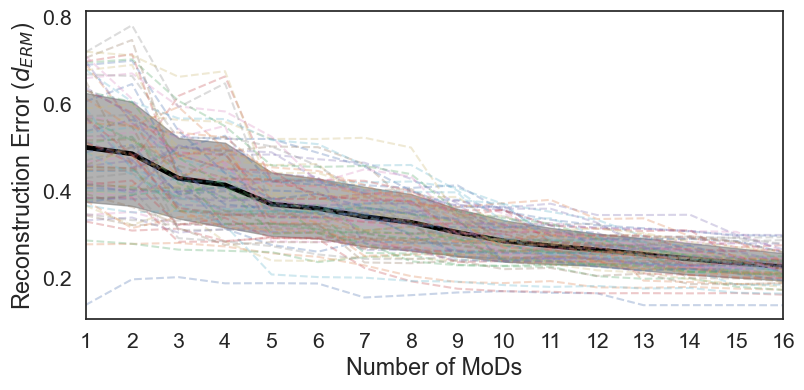

In [15]:
sns.set_context('notebook', font_scale=1.4)

total_l2d = np.array(total_l2d)
mean_l2d = np.mean(total_l2d, axis=0)
std_l2d = np.std(total_l2d, axis=0)
print (np.mean(total_l2d,axis=0).shape)

fig = plt.figure(figsize=(9, 4), dpi=100)
ax = fig.add_subplot(111)
ax .plot(np.mean(total_l2d,axis=0),linestyle='-', color='black', linewidth=3.5)
# 绘制标准差带
ax.fill_between(range(len(mean_l2d)), mean_l2d - std_l2d, mean_l2d + std_l2d, color='gray', alpha=0.6)
for i in range(79):
    ax.plot(total_l2d[i],linestyle='--', alpha=0.3, linewidth=1.5)
ax.autoscale(enable=True, axis='x', tight=True)

# 获取当前x轴的刻度位置（默认是从0开始）并加1来变成从1开始
ticks = np.arange(len(mean_l2d))  # 生成从0到len(mean_l2d)-1的整数数组
ax.set_xticks(ticks)  # 设置x轴的刻度位置
ax.set_xticklabels(ticks + 1)  # 设置x轴的刻度标签，从1开始
ax.set_xlabel('Number of MoDs')
ax.set_ylabel('Reconstruction Error ($d_{ERM}$)')

print (sorted(g_dist_mat.flatten()))

In [16]:
def save_vtk_text(filename, all_points, num_components, component_values):
    with open(filename, 'w') as f:
        # Write the header
        f.write("# vtk DataFile Version 2.0\n")
        f.write("3D curve data\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        # Write the points
        total_points = sum(len(points) for points in all_points)
        f.write(f"POINTS {total_points} float\n")
        point_offset = 0
        for points in all_points:
            for point in points:
                f.write(f"{point[0]} {point[1]} {point[2]}\n")

        # Write the lines
        f.write(f"LINES {num_components} {total_points + num_components}\n")
        point_index = 0
        for points in all_points:
            f.write(f"{len(points)} ")
            for i in range(len(points)):
                f.write(f"{point_index + i} ")
            f.write("\n")
            point_index += len(points)
        # Write the cell data
        f.write(f"CELL_DATA {num_components}\n")
        f.write("SCALARS ComponentValue int 1\n")
        f.write("LOOKUP_TABLE default\n")
        for value in component_values:
            f.write(f"{value+1}\n")

for curve_idx in [60, 5, 53]:
    all_points = []
    component_values = []
    for i in range(tPCA_N_COMPONENTS):
        ft = tangent_projected_data[curve_idx, :].copy()
        ft[i:] = 0
        ft[i] = ft[i] *  np.random.uniform(-1.5, 1.5)
        reconstructed_step_curve = from_tangentPCA_feature_to_curves(tpca, tangent_base, np.array([ft]), 
                                                                      tPCA_N_COMPONENTS, 
                                                                      discrete_curves_space)[0]
        # Adjust the z-coordinate to separate the curves
        points = reconstructed_step_curve[:, [2, 1, 0]]*2.5  # Adjust the order of columns if necessary
        points[:, 0] += i * 0.5
        all_points.append(points)
        component_values.append(i)

    filename = f'curve_{curve_idx}_magic.vtk'
    print(f'Saving {filename}')
    # save_vtk_text(filename, all_points, tPCA_N_COMPONENTS, component_values)


Saving curve_60_magic.vtk
Saving curve_5_magic.vtk
Saving curve_53_magic.vtk


In [77]:
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# sns.set_context('notebook', font_scale=1.15)
# mean_tangent_projected_data = np.mean(tangent_projected_data, axis=0)
# std_tangent_projected_data = np.std(tangent_projected_data, axis=0)
# print (mean_tangent_projected_data.shape)

# # 生成一个包含所有可能偏移的数据集
# atlas_projected_data = []


# time_length= 15
# sigma=np.linspace(-1.5,1.5,time_length)
# for i in range(tPCA_N_COMPONENTS):
#     for j in sigma:
#         a_project_data = mean_tangent_projected_data.copy()
#         a_project_data[i] += std_tangent_projected_data[i]*j
#         atlas_projected_data.append(a_project_data)
# atlas_projected_data = np.array(atlas_projected_data)
# print (atlas_projected_data.shape)
# atlas_projected_data= atlas_projected_data.reshape(tPCA_N_COMPONENTS,time_length,-1)
# print (atlas_projected_data.shape)

# num_curves = len(sigma)  # 获取曲线的数量

# # 创建颜色映射和标准化对象
# cmap = plt.get_cmap('crest')
# norm = mcolors.Normalize(vmin=0, vmax=num_curves-1)

# # 使用 ScalarMappable 来映射颜色
# scalar_mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

# def align_one_to_all(obj_curvature, fft_c):
#     obj_c_temp = fs.fdawarp(np.vstack([obj_curvature.fmean, fft_c]).T, time)
#     # 使用 srsf_align 对新数据进行对齐，假设 mean_curve 是第一个数据
#     obj_c_temp.srsf_align(MaxItr=100, parallel=True)
#     # 获取对齐后的数据
#     print ("obj_c_temp.fn:", obj_c_temp.fn.shape)
#     aligned_fft_c = obj_c_temp.fn[:, 1]  # 获取第二行，即新对齐的数据
#     new_data_warping = obj_c_temp.gam[:,1]
#     return aligned_fft_c, new_data_warping

# print ("atlas_projected_data.shape:",atlas_projected_data.shape)


# synthetic_fpca_loadings = []
# for atlas_projected_d in atlas_projected_data:
#     print (atlas_projected_d.shape)
#     # fig_s = plt.figure(figsize=(9,8), dpi=50)
#     # ax_s = fig_s.add_subplot(111)
#     # sns.scatterplot(x=tangent_projected_data[:, 0], y=tangent_projected_data[:, 1], edgecolor='black',c="white",ax=ax_s)
#     fig = plt.figure(figsize=(18,9), dpi=100)
#     gs = gridspec.GridSpec(2, 3, height_ratios=[5,5], width_ratios=[2, 8, 3])
#     # The first subplot (standard deviation line plot).
#     ax1 = fig.add_subplot(gs[:, 0])  # First row, first column
#     ax2 = fig.add_subplot(gs[0, 1])  # Second row, first column
#     ax3 = fig.add_subplot(gs[1, 1])  # First row, second column
#     ax4 = fig.add_subplot(gs[0, 2])  # Second row, second column
#     ax5 = fig.add_subplot(gs[1, 2])  # First row, second column
#     # sns.scatterplot(x=atlas_projected_d[:, 0], y=atlas_projected_d[:, 1], edgecolor='black',c=range(len(atlas_projected_d)),cmap=cmap,ax=ax_s)
#     atlas_reconstructed_synthetic_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, atlas_projected_d, 
#                                                                                 tPCA_N_COMPONENTS, 
#                                                                                 discrete_curves_space)
#     print (atlas_reconstructed_synthetic_curves.shape)
        
#     # 假设 reconstructed_synthetic_curves 是已定义的曲线数组
#     for i in range(len(atlas_reconstructed_synthetic_curves)):
#         # 获取当前索引的颜色
#         # print (atlas_reconstructed_synthetic_curves[i].shape)
#         color = scalar_mappable.to_rgba(i)
#         # 绘制曲线
#         # sns.lineplot(x=atlas_reconstructed_synthetic_curves[i][:, 0], y=atlas_reconstructed_synthetic_curves[i][:, 1], linewidth=1, color=color, ax=ax1)
        
#         ax1.plot(atlas_reconstructed_synthetic_curves[i][:,0],atlas_reconstructed_synthetic_curves[i][:,1], linewidth=2,color=color)
#         c,t = compute_curvature_and_torsion(atlas_reconstructed_synthetic_curves[i]*180)
#         fft_c= remove_high_freq_components(c,0.06)
#         fft_t = remove_high_freq_components(t,0.06)
#         # print (obj_curvature.fmean.shape, fft_c.shape, time.shape,np.stack([obj_curvature.fmean, fft_c]).T.shape)
        
#         # 如果需要，也可以获取时间扭曲函数
#         aligned_fft_c, new_data_warping_c = align_one_to_all(obj_curvature, fft_c)
#         aligned_fft_t, new_data_warping_t = align_one_to_all(obj_torsion, fft_t)

#         # new_data_srsf_c = np.append(fs.f_to_srsf(aligned_fft_c, obj_curvature.time),0)
#         # print ("new_data_srsf_c:",new_data_srsf_c.shape, vpca_curvature.q_pca.shape, vpca_curvature.mqn.shape)
#         # loadings_c = np.dot(vpca_curvature.q_pca, new_data_srsf_c - vpca_curvature.mqn)
#         # new_data_srsf_t = np.append(fs.f_to_srsf(aligned_fft_t, obj_torsion.time),0)
#         # loadings_t = np.dot(vpca_torsion.q_pca, new_data_srsf_t - vpca_torsion.mqn)
#         # synthetic_fpca_loadings.append((loadings_c,loadings_t))


#         ax2.plot(aligned_fft_c ,color=color)
#         # ax2.plot(obj_curvature.fmean,color='k')
#         ax3.plot(aligned_fft_t ,color=color)
#         ax4.plot(new_data_warping_c ,color=color)
#         ax5.plot(new_data_warping_t ,color=color)
#         ax4.plot([0,119],[0,1],c='k', linestyle='--')
#         ax5.plot([0,119],[0,1],c='k', linestyle='--')
#     for ax in [ax2,ax3,ax4,ax5]:
#         ax.autoscale(enable=True, axis='x', tight=True)
#         # ax.grid(linestyle='--', linewidth=0.5, alpha=0.7)
#         ax.set_xticks(np.linspace(0, len(autocovariance_values), num=5))  # 在0到199之间平均放置5个刻度
#         # 设置横轴的刻度标签，将其转换为百分比
#         ax.set_xticklabels(['{}'.format(x) for x in np.linspace(0, 1, num=5)])
#     plt.tight_layout()



In [19]:


# print (np.vstack([kappa_dot, tau_dot]).T.shape)
# print (c_peak_movement.shape)

# 假设tangent_projected_data是你的数据数组
# 提取前三个维度作为点坐标
points = tangent_projected_data[:, :3]
 

kappa_tau_dots = np.vstack([kappa_moves,tau_moves,kappa_values,tau_values]).T
# attributes = np.hstack([c_peak_movement,t_peak_movement,c_peak_values,t_peak_values,kappa_tau_dots])
# attribute_names = ['c_peak_movement_0','c_peak_movement_1','c_peak_movement_2','c_peak_movement_3','c_peak_movement_4',
#                     't_peak_movement_0','t_peak_movement_1','t_peak_movement_2','t_peak_movement_3','t_peak_movement_4',
#                     'c_peak_values_0','c_peak_values_1','c_peak_values_2','c_peak_values_3','c_peak_values_4',
#                     't_peak_values_0','t_peak_values_1','t_peak_values_2','t_peak_values_3','t_peak_values_4',
#                     "kappa_moves","tau_moves","kappa_values","tau_values"]

attributes = np.vstack([kappa_moves,tau_moves,kappa_values,tau_values]).T
attribute_names = ["kappa_moves","tau_moves","kappa_values","tau_values"]



def generate_vtk_with_curves(filename, points, curve_bs, attribute_names, attributes):
    """
    生成包含点和对应曲线的VTK文件，确保每个曲线的中心落在对应的点上
    :param filename: 输出的VTK文件名
    :param points: 点的坐标列表
    :param curve_bs: 曲线的坐标列表，每个点对应一条曲线
    :param attribute_names: 属性名称列表
    :param attributes: 属性值列表
    """
    with open(filename, 'w') as file:
        file.write("# vtk DataFile Version 3.0\n")
        file.write("tangent_project_data\n")
        file.write("ASCII\n")
        file.write("DATASET POLYDATA\n")

        total_points = len(points) * len(curve_bs[0])
        file.write(f"POINTS {total_points} float\n")

        for i, point in enumerate(points):
            curve = curve_bs[i]
            curve_center = np.mean(curve, axis=0)
            adjusted_curve = curve - curve_center + point
            for c in adjusted_curve:
                file.write(f"{c[0]} {c[1]} {c[2]}\n")

        total_lines = len(points)
        line_size = len(curve_bs[0])
        file.write(f"LINES {total_lines} {total_lines * (1 + line_size)}\n")
        
        for i in range(len(points)):
            file.write(f"{line_size}")
            for j in range(line_size):
                file.write(f" {i * line_size + j}")
            file.write("\n")

        file.write(f"CELL_DATA {total_lines}\n")
        for i, name in enumerate(attribute_names):
            file.write(f"SCALARS {name} float 1\n")
            file.write("LOOKUP_TABLE default\n")
            for attribute in attributes:
                file.write(f"{attribute[i]}\n")


# generate_vtk_with_curves('tangent_project_data_v2.vtk', points, curve_bs, attribute_names, attributes)
# generate_vtk_with_curves('pca_data_v2.vtk', points, curve_bs, attribute_names, attributes)
# generate_vtk_with_curves('pca_project_v2_2.vtk', results[:,:3], curve_bs*20, attribute_names, attributes)

In [20]:
def translate_curve(curve, target_point):
    """
    计算曲线的3D重心并将其平移到新的2D目标点。
    
    参数:
    curve : ndarray
        曲线的点坐标，形状为 (n, 3)。
    target_point : ndarray
        目标点的2D坐标，形状为 (2,)。
    
    返回:
    translated_x : ndarray
        平移后曲线的x坐标。
    translated_y : ndarray
        平移后曲线的y坐标。
    """
    # 计算3D重心
    centroid = np.mean(curve, axis=0)
    
    # 计算x和y方向的位移
    dx = target_point[0] - centroid[0]
    dy = target_point[1] - centroid[1]
    
    # 平移曲线
    translated_x = curve[:, 0] + dx
    translated_y = curve[:, 1] + dy
    
    return translated_x, translated_y

821


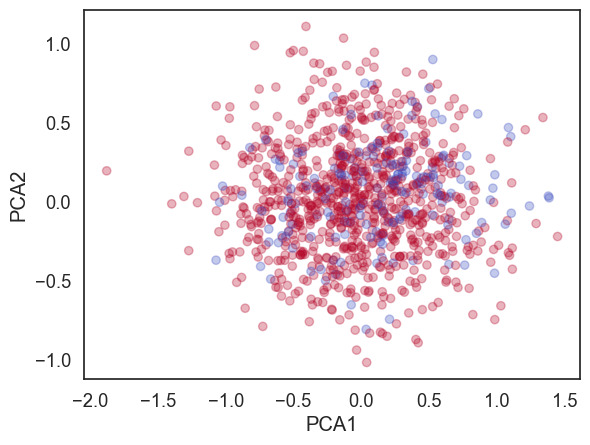

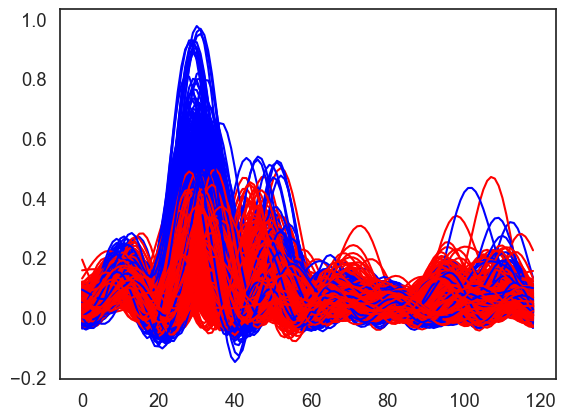

In [102]:
from scipy.stats import gaussian_kde

def fit_gaussian(data):
    # 计算数据的均值和标准差
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)

    # 创建一个高斯分布对象数组
    gaussians = [norm(loc=mean[i], scale=std[i]) for i in range(len(mean))]
    return gaussians

def generate_random_pca(gaussians, n_samples):
    random_pca = np.array([gaussian.rvs(size=n_samples) for gaussian in gaussians]).T
    return random_pca

def fit_kde(data, bandwidth=None):
    # 为每个主成分拟合KDE，可以调整带宽
    kdes = [gaussian_kde(data[:, i], bw_method=bandwidth) for i in range(data.shape[1])]
    return kdes

def generate_random_pca_from_kde(kdes, n_samples):
    random_pca = np.array([kde.resample(n_samples).flatten() for kde in kdes]).T
    return random_pca


gaussian_tangent_projected_data = fit_gaussian(tangent_projected_data)
n_random_samples = 1000  # 生成10个随机样本
gaussian_MoDs = generate_random_pca(gaussian_tangent_projected_data, n_random_samples)

bandwidth = 1  # 示例带宽值，可以调整
# 拟合KDE
kde_tangent_projected_data = fit_kde(tangent_projected_data, bandwidth)
# 生成随机的主成分分布
kde_MoDs = generate_random_pca_from_kde(kde_tangent_projected_data, n_random_samples)




kde_reconstructed_curves = from_tangentPCA_feature_to_curves(tpca, tangent_base, gaussian_MoDs, 
                                                                              tPCA_N_COMPONENTS, 
                                                                              discrete_curves_space)
gaussian_curvatures = []
gaussian_torsions = []
# plt.plot(obj_curvature.fmean, label='Curvature')

temp_kde_dir = mkdir('./', 'kde_reconstructed_curves')
for i in range(len(kde_reconstructed_curves)):
    # plt.plot(kde_reconstructed_curves[i][:, 0], kde_reconstructed_curves[i][:, 1], linewidth=1)
    c, t = compute_curvature_and_torsion(kde_reconstructed_curves[i]*180)
    fft_c = remove_high_freq_components(c, 0.06)

    fft_t = remove_high_freq_components(t, 0.06)
    gaussian_curvatures.append(fft_c)
    gaussian_torsions.append(fft_t)


# 计算每一行的最大值
max_values = np.max(gaussian_curvatures, axis=1)

# 生成新数列：如果最大值大于0.5就为0，否则为1
new_array = np.where(max_values > 0.5, 0, 1)
print (np.sum(new_array))
# plt.scatter(tangent_projected_data[:, 0], tangent_projected_data[:, 1], c='k', label='Original Data', alpha=0.5)
plt.scatter(gaussian_MoDs[:, 0], gaussian_MoDs[:, 1],c=new_array, cmap='coolwarm',alpha=0.3)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
# plt.legend()
plt.show()

for i in range(len(gaussian_curvatures)):
    color = 'blue' if max_values[i] > 0.5 else 'red'
    plt.plot(gaussian_curvatures[i], color=color)
plt.show()

kappa_moves
(79,)
Bin edges for y_continuous: [-0.08643589 -0.04151824 -0.01555765  0.00255203  0.03435237  0.12438563]
Bin 0: -0.0864 to -0.0415
Bin 1: -0.0415 to -0.0156
Bin 2: -0.0156 to 0.0026
Bin 3: 0.0026 to 0.0344
Bin 4: 0.0344 to 0.1244
Best Parameters: {'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.25       0.625      0.5        0.625      0.33333333]
Mean Cross-validation Accuracy: 0.4666666666666667
(27000, 5)


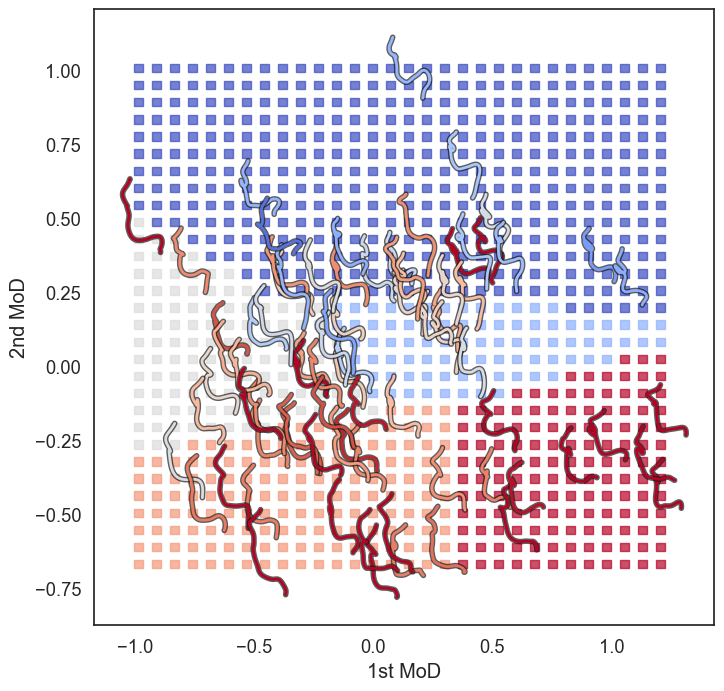

=====
tau_moves
(79,)
Bin edges for y_continuous: [-0.0820833  -0.03961377 -0.01379837  0.00306054  0.03440837  0.11447978]
Bin 0: -0.0821 to -0.0396
Bin 1: -0.0396 to -0.0138
Bin 2: -0.0138 to 0.0031
Bin 3: 0.0031 to 0.0344
Bin 4: 0.0344 to 0.1145
Best Parameters: {'C': 600, 'gamma': 0.01, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.25       0.75       0.5        0.5625     0.26666667]
Mean Cross-validation Accuracy: 0.4658333333333333
(27000, 5)


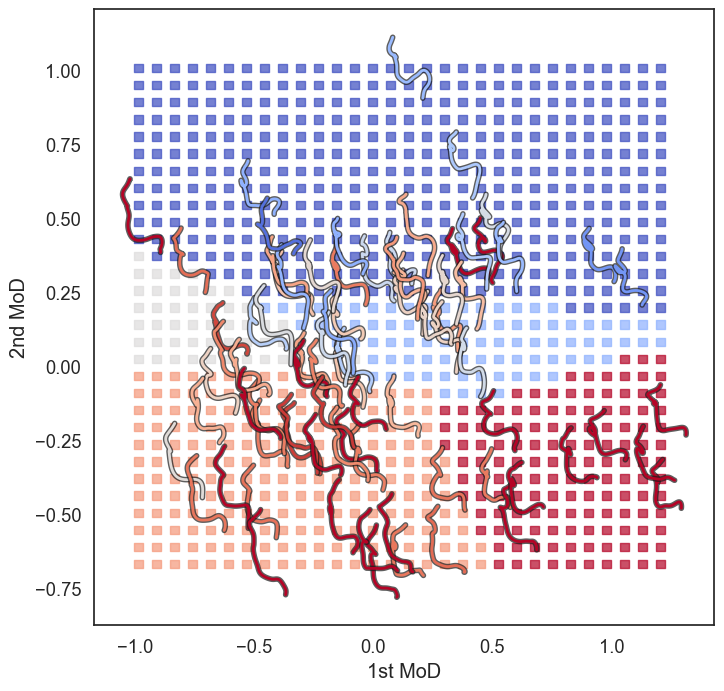

=====
kappa_values
(79,)
Bin edges for y_continuous: [0.699175   0.86496445 0.97079192 1.04498377 1.17355863 1.48536591]
Bin 0: 0.6992 to 0.8650
Bin 1: 0.8650 to 0.9708
Bin 2: 0.9708 to 1.0450
Bin 3: 1.0450 to 1.1736
Bin 4: 1.1736 to 1.4854
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.3125     0.375      0.25       0.5625     0.46666667]
Mean Cross-validation Accuracy: 0.39333333333333337
(27000, 5)


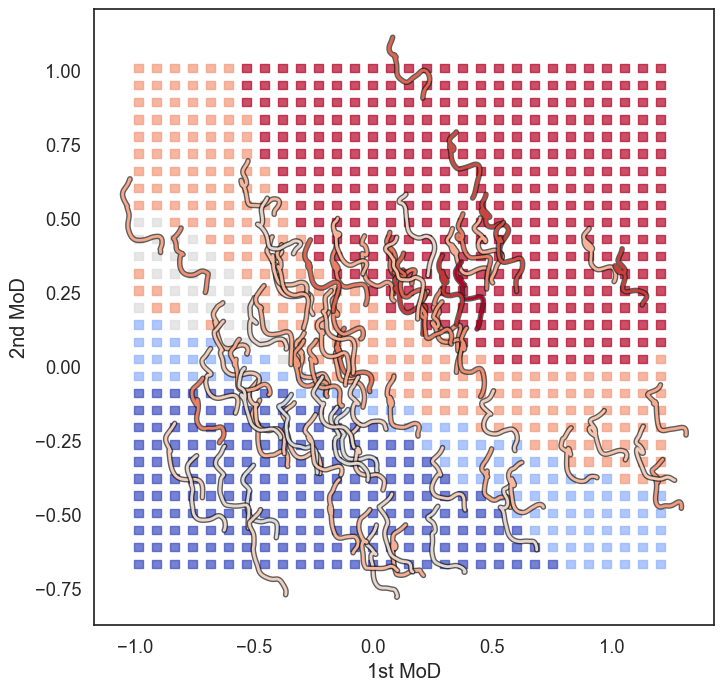

=====
tau_values
(79,)
Bin edges for y_continuous: [-0.68984057  0.70450161  1.09756813  1.43667429  1.82606424  2.92974638]
Bin 0: -0.6898 to 0.7045
Bin 1: 0.7045 to 1.0976
Bin 2: 1.0976 to 1.4367
Bin 3: 1.4367 to 1.8261
Bin 4: 1.8261 to 2.9297
Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Cross-validation Accuracy Scores: [0.375  0.1875 0.125  0.4375 0.4   ]
Mean Cross-validation Accuracy: 0.305
(27000, 5)


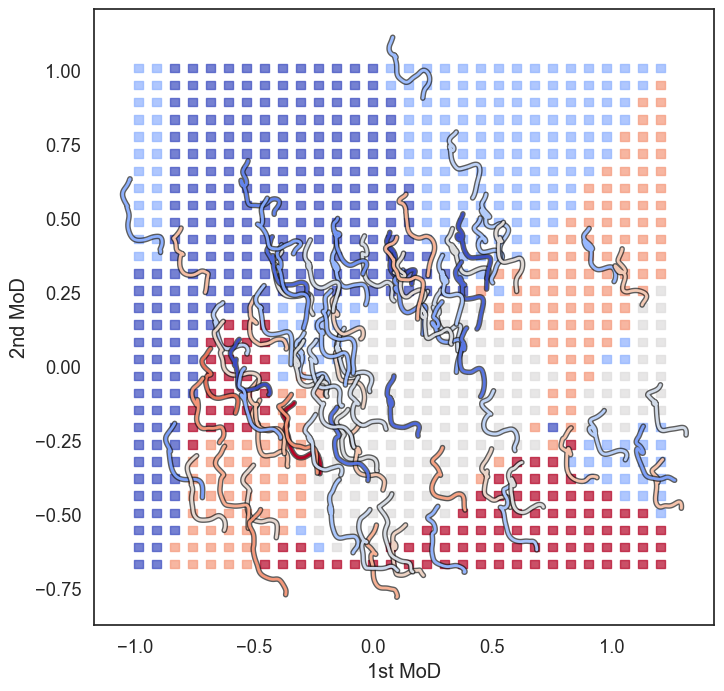

=====


In [103]:

svm_dir = mkdir("./", "svm")


# 将每组相邻类之间的决策边界写入VTK文件
def write_vtk(filename, decision_values, n_classes, x_range, y_range, z_range):
    polydata = vtk.vtkPolyData()
    points = vtk.vtkPoints()
    polys = vtk.vtkCellArray()
    cell_labels = vtk.vtkIntArray()
    cell_labels.SetName("BoundaryLabel")
    
    point_index_offset = 0

    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            decision_boundary = decision_values[:, i] - decision_values[:, j]
            decision_boundary = decision_boundary.reshape((grid_size, grid_size, grid_size))
            
            # 找到决策边界，确保level在数据范围内
            min_value, max_value = decision_boundary.min(), decision_boundary.max()
            level = 0.5 * (min_value + max_value)
            verts, faces, normals, values = measure.marching_cubes(decision_boundary, level=level)
            
            # 将 verts 转换到原始坐标范围并添加到 points 和 polys 中
            for vert in verts:
                x = x_range[0] + vert[0] * (x_range[-1] - x_range[0]) / (len(x_range) - 1)
                y = y_range[0] + vert[1] * (y_range[-1] - y_range[0]) / (len(y_range) - 1)
                z = z_range[0] + vert[2] * (z_range[-1] - z_range[0]) / (len(z_range) - 1)
                points.InsertNextPoint(x, y, z)

            for face in faces:
                polys.InsertNextCell(3)
                polys.InsertCellPoint(face[0] + point_index_offset)
                polys.InsertCellPoint(face[1] + point_index_offset)
                polys.InsertCellPoint(face[2] + point_index_offset)
                cell_labels.InsertNextValue(i * n_classes + j)

            point_index_offset += len(verts)

    polydata.SetPoints(points)
    polydata.SetPolys(polys)
    polydata.GetCellData().AddArray(cell_labels)

    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(filename)
    writer.SetInputData(polydata)
    writer.Write()

# 将grid数据和预测标签写入.particles文件
def write_particles_with_labels(filename, grid, labels):
    with open(filename, 'w') as f:
        for point, label in zip(grid, labels):
            f.write(f"{point[0]} {point[1]} {point[2]} {label}\n")

grid_size =  30  # 网格点的数量

# 对连续的属性值进行分桶操作，将其转换为离散标签
# attribute_index = 1  # 选择要用来分类的属性索引
for attribute_index in range(len(attribute_names)):
    print (attribute_names[attribute_index])
    y_continuous = attributes[:, attribute_index]

    # 使用KBinsDiscretizer进行分桶
    n_bins = 5 # 这里我们将连续属性值分成四个桶
    kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = kbins.fit_transform(y_continuous.reshape(-1, 1)).astype(int).ravel()
    print (y_binned.shape)
    # 获取并打印每个桶的边界
    bin_edges = kbins.bin_edges_[0]  # bin_edges_ 是一个列表的列表，每个子列表对应一个特征的边界
    print("Bin edges for y_continuous:", bin_edges)

    # 打印每个桶对应的连续值范围
    for i in range(len(bin_edges) - 1):
        print(f"Bin {i}: {bin_edges[i]:.4f} to {bin_edges[i+1]:.4f}")


    # 使用tangent_projected_data作为X
    X = tangent_projected_data[:, :3]

    # # 训练SVM模型
    # svm = SVC(kernel='rbf', C=1, gamma='auto', decision_function_shape='ovr')
    # svm.fit(X, y_binned)

    param_grid = {
        'C': [0.1, 1, 10, 100, 600],  # 扩展到更高和更低的C值
        'gamma': [0.001, 0.01, 0.1, 1, 10],  # 同样适用对数尺度扩展gamma
        'kernel': ['rbf']
    }



    # 创建 SVM 模型
    svm = SVC(decision_function_shape='ovr')

    # 创建 GridSearchCV 实例
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=0)

    # 进行参数调优
    grid_search.fit(X, y_binned)

    # 输出最优参数
    print("Best Parameters:", grid_search.best_params_)

    # 使用最优参数训练最终模型
    best_svm = grid_search.best_estimator_

    # 使用交叉验证评估模型性能
    cv_scores = cross_val_score(best_svm, X, y_binned, cv=5, scoring='accuracy')
    print("Cross-validation Accuracy Scores:", cv_scores)
    print("Mean Cross-validation Accuracy:", np.mean(cv_scores))

    # 创建网格点以绘制决策边界
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size)
    z_range = np.linspace(X[:, 2].min(), X[:, 2].max(), grid_size)
    xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
    grid = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # 预测每个网格点的标签
    decision_values = best_svm.decision_function(grid)
    grid_predictions = best_svm.predict(grid)
    print (decision_values.shape)


    vis_decision_value = decision_values.reshape((grid_size, grid_size, grid_size, -1))
    # print (vis_decision_value.shape)
    category_indices = np.argmax(vis_decision_value, axis=-1)

    z_index = z_range[z_range.shape[0] // 2]  # 选择中间的 z 值
    selected_points = grid[grid[:, 2] == z_index]
    # 获取对应的类别索引
    selected_categories = category_indices.reshape(-1)[grid[:, 2] == z_index]
    # print (selected_points.shape)

    sns.set_context('notebook', font_scale=1.2)
    # 创建一个 3D 散点图
    fig = plt.figure(figsize=(8, 8), dpi=100)
    ax = fig.add_subplot(111)


    scatter = ax.scatter(selected_points[:, 0], selected_points[:, 1],c=selected_categories,  marker='s', cmap='coolwarm', alpha=0.7)

    # 添加颜色条
    # fig.colorbar(scatter, ax=ax, label='Category')
    for i in range(len(curve_cs)):
        # plt.plot(curve_cs[i][:,0],curve_cs[i][:,1],c='k')
        translated_x, translated_y = translate_curve(curve_cs[i]/2, tangent_projected_data[i, :2])
        plt.plot(translated_x, translated_y,  linewidth=4, c='k', alpha=0.7)
        if "value" in attribute_names[attribute_index]:
            plt.plot(translated_x, translated_y,  linewidth=2, c=cm.coolwarm((y_continuous[i])/max(y_continuous)), alpha=1)
        else:
            plt.plot(translated_x, translated_y,  linewidth=2, c=cm.coolwarm((y_continuous[i]-min(y_continuous))/max(y_continuous)-min(y_continuous)), alpha=1)
    ax.set_xlabel('1st MoD')
    ax.set_ylabel('2nd MoD')
    plt.show()


    # write_vtk(svm_dir + "decision_boundaries_{}.vtk".format(attribute_names[attribute_index]), decision_values, n_bins, x_range, y_range, z_range)
    # write_particles_with_labels(svm_dir + "grid_particles_with_labels_{}.particles".format(attribute_names[attribute_index]), grid, grid_predictions)
    print ("=====")

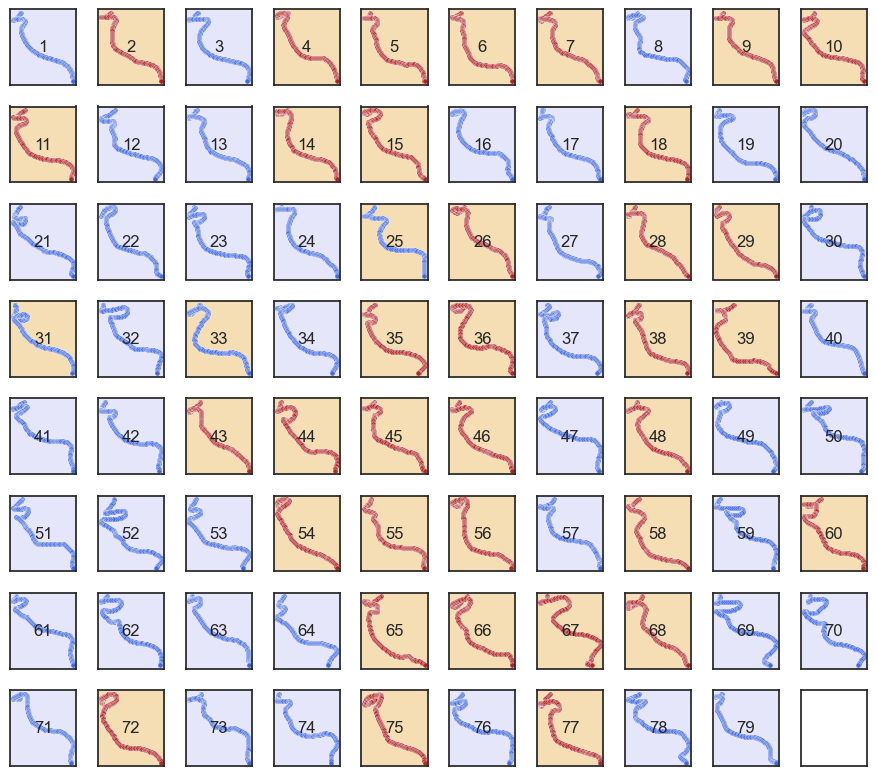

In [105]:
def rotate_curves(curves, angle, axis):
    """
    旋转3D曲线数据集。
    
    :param curves: numpy数组，形状为(n, k, 3)，n是曲线数，k是每条曲线的点数。
    :param angle: 旋转角度，以度为单位。
    :param axis: 旋转轴，'x'、'y'或'z'。
    :return: 旋转后的曲线数据集。
    """
    # 将角度从度转换为弧度
    theta = np.radians(angle)
    
    # 根据轴选择旋转矩阵
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        R = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        R = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # 应用旋转矩阵到每个点
    rotated_curves = np.dot(curves, R.T)
    
    return rotated_curves

ro = rotate_curves(curve_cs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8))


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            # elastic_c = round(np.dot(c_peak_movement[i*col+j], c_peak_values[i*col+j]),3)
            # elastic_t = round(np.dot(t_peak_movement[i*col+j], t_peak_values[i*col+j]),3)
            elastic_c = round(np.sum(c_peak_movement[i*col+j]),3)
            elastic_t = round(np.sum(t_peak_movement[i*col+j]),3)
            shift_c.append(elastic_c)
            shift_t.append(elastic_t)
            if elastic_c > 0:
                scattercolor = 'firebrick'
            else:
                scattercolor = 'royalblue'

            if elastic_t < 0:
                facecolor = 'lavender'
            else:
                facecolor = 'wheat'
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=0.9,s=14, color=scattercolor)
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.5, 0.5, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


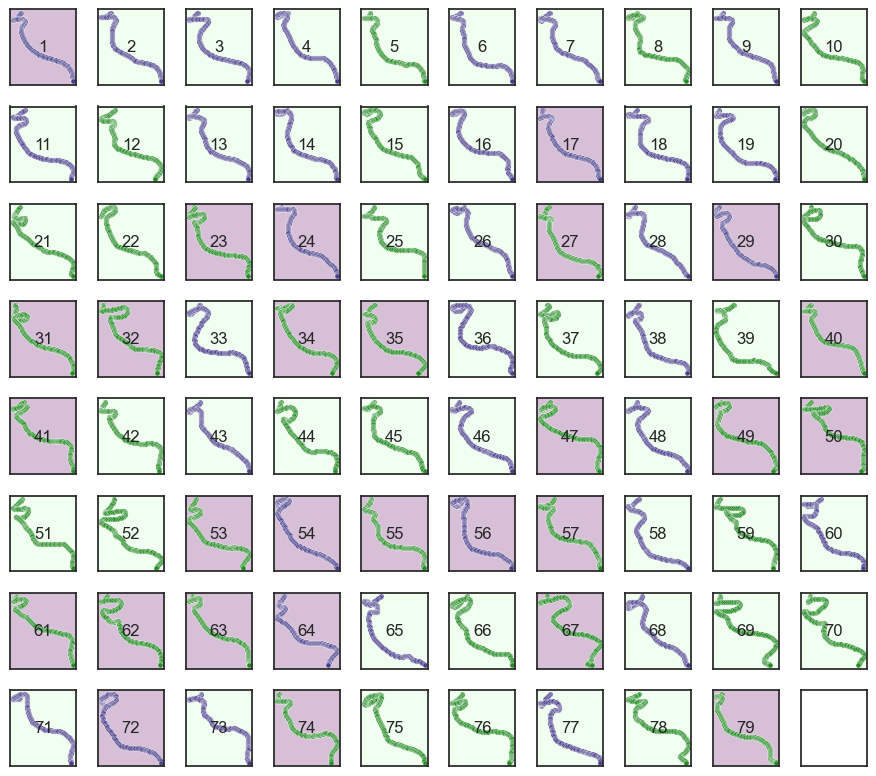

In [106]:


ro = rotate_curves(curve_cs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8))

# 遍历每个子图，并在其中绘制一些数据
intense_c = []
intense_t = []
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            # elastic_c = round(np.dot(c_peak_movement[i*col+j], c_peak_values[i*col+j]),3)
            # elastic_t = round(np.dot(t_peak_movement[i*col+j], t_peak_values[i*col+j]),3)
            # elastic_c = round(np.sum(c_peak_values[i*col+j]),3)
            # elastic_t = round(np.sum(t_peak_values[i*col+j]),3)
            elastic_c = round(np.mean(c_peak_values[i*col+j]),3)
            elastic_t = round(np.mean(t_peak_values[i*col+j]),3)
            intense_c.append(elastic_c)
            intense_t.append(elastic_t)
            if elastic_c > 1:
                scattercolor = 'forestgreen'
            else:
                scattercolor = 'darkslateblue'
            if elastic_t < 1:
                facecolor = 'thistle'
            else:
                facecolor = 'honeydew'
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=0.9,s=14, color=scattercolor)
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.5, 0.5, f'{i*col + j + 1}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()

shift_c = np.array(shift_c)
shift_t = np.array(shift_t)
intense_c = np.array(intense_c)
intense_t = np.array(intense_t)


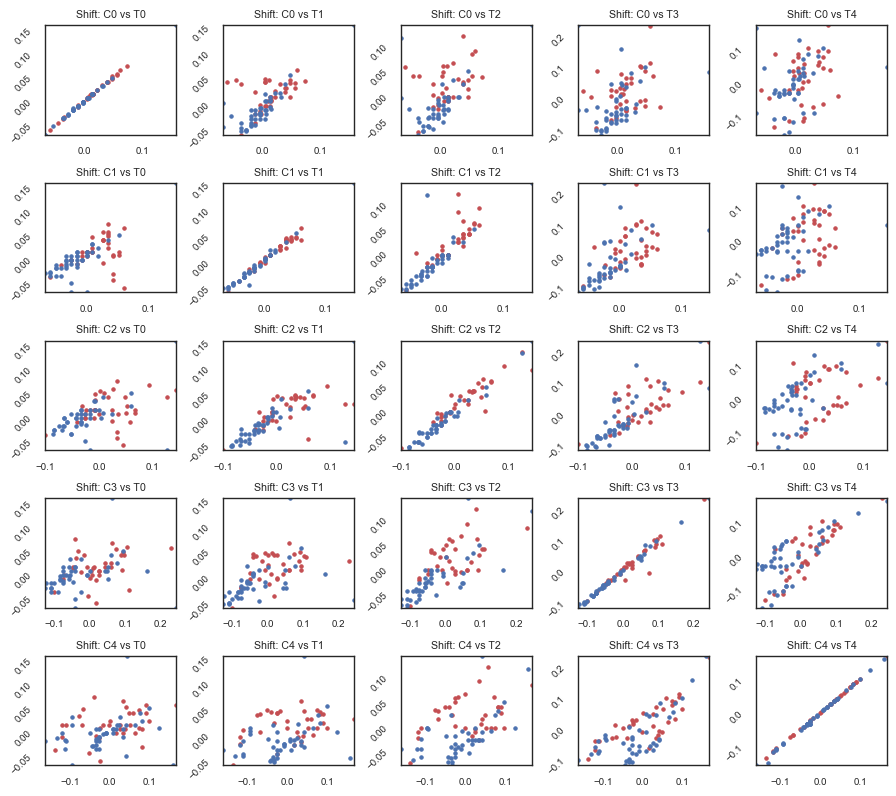

In [107]:
row = 5
col = 5

shift_c = np.array(shift_c)
shift_t = np.array(shift_t)
intense_c = np.array(intense_c)
intense_t = np.array(intense_t)
sns.set_context('paper', font_scale=0.8)
sns.set_style('white')
for c_item in [c_peak_movement]:
    for t_item in [t_peak_movement]:
        fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8), dpi=100)
        # 遍历每个子图，并在其中绘制一些数据
        for i in range(row):
            for j in range(col):
                ax = axes[i, j]  # 获取单个子图对象

                mask_0 = (intense_c < 1)
                mask_1 = (intense_c >= 1)
                ax.scatter(c_item[mask_0, i], t_item[mask_0, j], alpha=1, marker='.', color="r")
                ax.scatter(c_item[mask_1, i], t_item[mask_1, j], alpha=1, marker='.', color="b")
                plt.setp(ax.get_yticklabels(), rotation=45)
                # plt.setp(ax.get_xticklabels(), rotation=45)
                # ax.set_ylim(-0.2, 0.2)
                ax.autoscale(enable=True, axis='x', tight=True)
                ax.autoscale(enable=True, axis='y', tight=True)
                ax.set_title(f'Shift: C{i} vs T{j}')
                
                
        plt.tight_layout()
        # plt.legend()

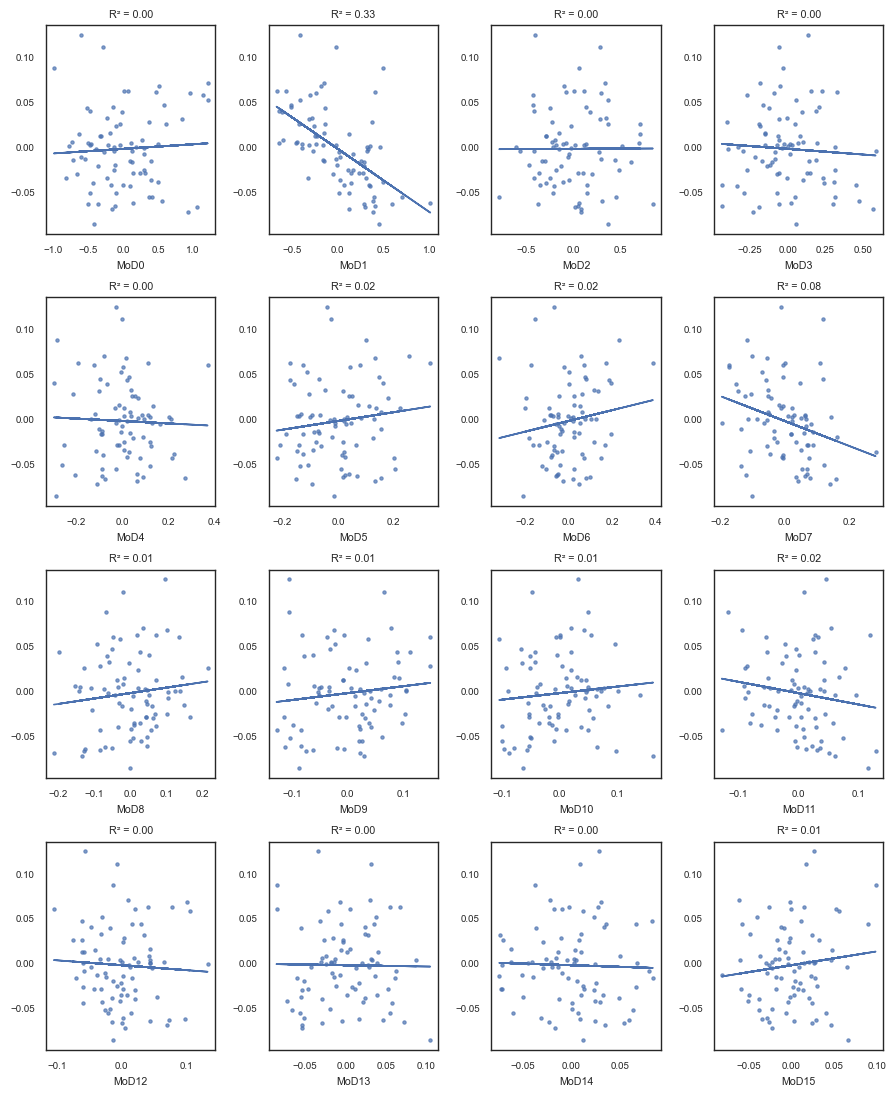

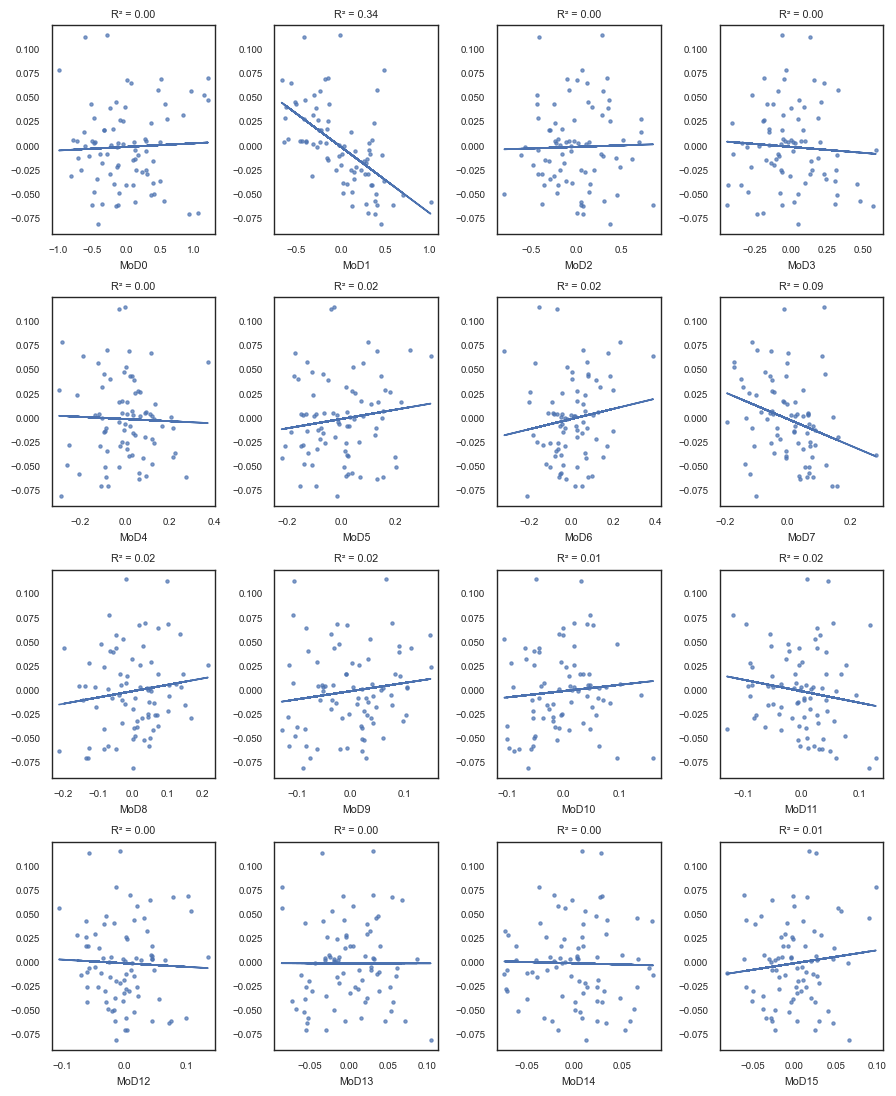

In [110]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assuming tangent_projected_data and c_peak_movement are already defined
row = 4
col = 4

# for item in [c_peak_values,t_peak_values]:
for item in [c_peak_movement,t_peak_movement]:
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 11))

    for i in range(row):
        for j in range(col):
            ax = axes[i, j]
            x = tangent_projected_data[:, row * i + j].reshape(-1, 1)
            y = np.mean(item, axis=1)

            # Scatter plot
            ax.scatter(x, y, alpha=0.7, marker='.')

            # Linear regression
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)

            # Plot the linear fit
            ax.plot(x, y_pred, color='b')

            # Evaluate the fit
            r2 = r2_score(y, y_pred)
            ax.set_title(f'R² = {r2:.2f}')
            ax.set_xlabel(f'MoD{row * i + j}')

    plt.tight_layout()
    plt.show()
